# Play ROI and videos from two separate sessions

In [1]:
import bokeh.plotting as bpl
import cv2
import glob
import holoviews as hv
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import pandas as pd
import tifffile

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.utils.visualization import view_quilt
from caiman.utils.visualization import get_contours
from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr

from ipywidgets import IntSlider, VBox
import fastplotlib as fpl
from fastplotlib.widgets import ImageWidget

# load local package/
import sys
root_dir = os.path.split(os.getcwd())[0] # get root
utils_dir = os.path.join(root_dir,'utils') # get utils folder path
sys.path.append(utils_dir) # add it to system path (not ideal) - doing this to reduce pip installs for local lab usage
import plot_tools as fpl_tools # import movie

def autocluster():
    #%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
    print(f"You have {psutil.cpu_count()} CPUs available in your current environment")
    num_processors_to_use = None
    print("Setting up new cluster")
    _, cluster, n_processes = cm.cluster.setup_cluster(backend='multiprocessing', 
                                                     n_processes=num_processors_to_use, 
                                                     ignore_preexisting=False)
    print(f"Successfully set up cluster with {n_processes} processes")
    return cluster, n_processes

# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (9, 9),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

caiman package loaded...
Suite2p not detected...


/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_54848/2638164036.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap('jet')


`fnames` refers to the paths to output from VizResults_miniscope

**Note** if you do not have such paths, then you didn't finish walking through the VizResults_miniscope notebook

In [2]:
fnames = [r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_02_06/12_21_26/miniscopeDeviceName/full_movie_20240320222511_cnmfe_new_new',
          r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_05/12_51_33/miniscopeDeviceName/full_movie_20240320224747_cnmfe_new',
          r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_15/10_57_51/miniscopeDeviceName/full_movie_20240320185923_cnmfe_new',
          r'/Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_21/15_01_43/miniscopeDeviceName/full_movie_20240322113218_cnmfe_new']
savepath = '/Users/js0403/miniscope/Figures'

# load data as list
ca_data = []; mask_data =[]; corr_data = []
[ca_data.append(np.load(os.path.join(i,'ca_traces.npy'),allow_pickle=True)) for i in fnames]
[mask_data.append(np.load(os.path.join(i,'mask.npy'),allow_pickle=True)) for i in fnames]
[corr_data.append(np.load(os.path.join(i,'corr_image.npy'),allow_pickle=True)) for i in fnames]

[None, None, None, None]

Get footprints/mask

In [3]:
mask_list=[]; footprint_list=[]; mask_contours=[]
for i in range(len(ca_data)):
    # get mask
    mask_list.append(ca_data[i].item()['mask'])
    mask_list[i][np.where(mask_list[i]==0)]=np.nan # set 0s to nan

    # get footprint and regen mask
    footprint_list.append(ca_data[i].item()['component_footprint'])
    #rand_scale = np.random.rand(1)*100
    for fi in range(len(footprint_list[i])):
        idx_above_zero = np.where(footprint_list[i][fi]>0)
        #footprint_list[i][fi][idx_above_zero]=np.random.rand(1)*100*(i+1)
        #footprint_list[i][fi][idx_above_zero]=rand_scale[0]
    footprint_list[i]=np.nanmax(np.array(footprint_list[i]),axis=0)
    #footprint_list[i][np.where(footprint_list[i]==0)]=np.nan

    # set to nan for mask_contour
    mask_contours.append(ca_data[i].item()['mask_contour'])
    #mask_contours[i][np.where(mask_contours[i]==0)]=np.nan
    #mask_contours[i][np.where(mask_contours[i]>0)]=(i+1)*100

Plot multisession array and save

saved to: /Users/js0403/miniscope/Figures


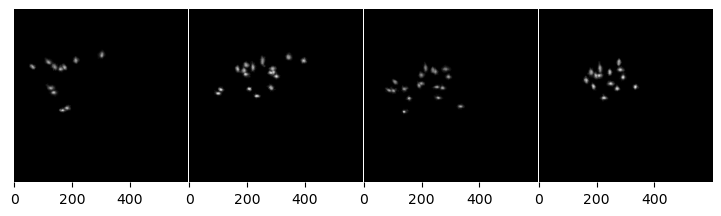

In [4]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=len(footprint_list))
for i in range(len(footprint_list)):
    ax[i].imshow(footprint_list[i],cmap='gray')
fig.savefig(os.path.join(savepath,'multisess.eps'),dpi=1000,facecolor='w')
print("saved to:",savepath)

plot ROI overlaid on the final correlation plot

In [5]:
len(ca_data[i].item()['component_contour'])

14

Create a figure with overlapping ROI, plot in a separate window and save out

In [8]:
%matplotlib qt 
plt.imshow(corr_data[-1],cmap='gray')
c_list = ['b','r','y','g']
for i in range(len(ca_data)):
    rois = ca_data[i].item()['component_contour']
    for ri in range(len(rois)):
        roi = rois[ri]
        plt.plot(roi.T[0,:],roi.T[1,:],c=c_list[i],linewidth=1)

#plt.xlim([50 450])
#plt.ylim([100 400])

In [2]:

# start cluster
if 'cluster' in locals():
    cluster.terminate()
cluster, n_processes = autocluster()

# load data
images_list = []; cm_list = []
for i in hdf5_fnames:
    # move directories
    root_path = os.path.split(i)[0] # extract root
    mov_path = os.path.join(root_path,'full_movie.tif')
    print("Working in:",root_path)

    # load caiman objects
    cnmfe_model = load_CNMF(i)

    # load memmory mapped file
    print("Loading:",cnmfe_model.mmap_file)
    Yr, dims, num_frames = cm.load_memmap(cnmfe_model.mmap_file)
    images = np.reshape(Yr.T, [num_frames] + list(dims), order='F')
    images_list.append(images) # cache

    # Threshold data for CNMFE
    min_SNR = 3      # SNR threshold - this could be lowered as needed, but you will get noise
    rval_thr = 0.99  # spatial correlation threshold - You should generally keep this
    
    # extract params
    cnmfe_params = cnmfe_model.params.__dict__
    
    # We need to reassign the fnames variable
    try: cnmfe_model.params.data['fnames'] = [cnmfe_model.params.data['fnames'][0].decode('UTF-8')]; 
    except: pass # dont change
    fr = cnmfe_model.params.data['fr'] # frame rate
    
    # changing parameters
    quality_params = {'min_SNR': min_SNR,
                      'rval_thr': rval_thr,
                      'use_cnn': False}
    cnmfe_model.params.change_params(params_dict=quality_params)
    
    # This is where the parameters above get put to test
    cnmfe_model.estimates.evaluate_components(images, cnmfe_model.params, dview=cluster)
    print('*****')
    print(f"Total number of components: {len(cnmfe_model.estimates.C)}")
    print(f"Number accepted: {len(cnmfe_model.estimates.idx_components)}")
    print(f"Number rejected: {len(cnmfe_model.estimates.idx_components_bad)}")

    # store caiman cnmf object
    cm_list.append(cnmfe_model)

You have 12 CPUs available in your current environment
Setting up new cluster
Successfully set up cluster with 11 processes
Working in: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_02_06/12_21_26/miniscopeDeviceName
Loading: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_02_06/12_21_26/miniscopeDeviceName/motioncorr_d1_600_d2_600_d3_1_order_C_frames_2851.mmap
*****
Total number of components: 15
Number accepted: 11
Number rejected: 4
Working in: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_05/12_51_33/miniscopeDeviceName
Loading: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_05/12_51_33/miniscopeDeviceName/motioncorr_d1_600_d2_600_d3_1_order_C_frames_3000.mmap
*****
Total number of components: 35
Number accepted: 20
Number rejected: 15
Working in: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Syn-GCaMP8f/2024_03_15/10_57_51/miniscopeDeviceName
Loading: /Users/js0403/miniscope/PFC-Neurons/122D/AAV2/3-Sy

In [12]:
# instantiate object
cnmf_plotter = fpl_tools.play_caiman_movie(images=images_list[0],cnmf_object=cm_list[0])
mov = cnmf_plotter.play_movie_draw_roi(components_type='accepted',show_movie=False)
mov.show(sidecar=True)

RFBOutputContext()

/Users/js0403/anaconda3/envs/caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-scale scene'), Button(icon='align-center', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-center scene'), ToggleButton(value=True, icon='hand-pointer', layout=Layout(width='auto'), tooltip='panzoom controller'), ToggleButton(value=True, description='1:1', layout=Layout(width='auto'), style=ToggleButtonStyle(font_weight='bold'), tooltip='maintain aspect'), Button(icon='arrow-down', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='y-axis direction'), Button(icon='draw-polygon', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='add PolygonSelector'), ToggleButton(value=False, icon='video', layout=Layout(width='auto'), tooltip='record'), Dropdown(description='Subplots:', layout=Layout(width='200px'), options=('(0, 0)',), value='(0, 0)'))), IpywidgetImageWidgetToolbar(children=(HBox

In [13]:
cnmf_plotter = fpl_tools.play_caiman_movie(images=images_list[1],cnmf_object=cm_list[1])
mov1 = cnmf_plotter.play_movie_draw_roi(components_type='accepted',show_movie=False)
mov1.show(sidecar=True)

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-scale scene'), Button(icon='align-center', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-center scene'), ToggleButton(value=True, icon='hand-pointer', layout=Layout(width='auto'), tooltip='panzoom controller'), ToggleButton(value=True, description='1:1', layout=Layout(width='auto'), style=ToggleButtonStyle(font_weight='bold'), tooltip='maintain aspect'), Button(icon='arrow-down', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='y-axis direction'), Button(icon='draw-polygon', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='add PolygonSelector'), ToggleButton(value=False, icon='video', layout=Layout(width='auto'), tooltip='record'), Dropdown(description='Subplots:', layout=Layout(width='200px'), options=('(0, 0)',), value='(0, 0)'))), IpywidgetImageWidgetToolbar(children=(HBox

In [14]:
cnmf_plotter = fpl_tools.play_caiman_movie(images=images_list[2],cnmf_object=cm_list[2])
mov1 = cnmf_plotter.play_movie_draw_roi(components_type='accepted',show_movie=False)
mov1.show(sidecar=True)

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-scale scene'), Button(icon='align-center', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='auto-center scene'), ToggleButton(value=True, icon='hand-pointer', layout=Layout(width='auto'), tooltip='panzoom controller'), ToggleButton(value=True, description='1:1', layout=Layout(width='auto'), style=ToggleButtonStyle(font_weight='bold'), tooltip='maintain aspect'), Button(icon='arrow-down', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='y-axis direction'), Button(icon='draw-polygon', layout=Layout(width='auto'), style=ButtonStyle(), tooltip='add PolygonSelector'), ToggleButton(value=False, icon='video', layout=Layout(width='auto'), tooltip='record'), Dropdown(description='Subplots:', layout=Layout(width='200px'), options=('(0, 0)',), value='(0, 0)'))), IpywidgetImageWidgetToolbar(children=(HBox

# Now lets do some plotting